In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json


In [2]:

#now read the json file using pandas

df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# Dataset Exploratory Data Analysis

In the dataset, if headline is sarcastic, "is_sarcastic" column value 1. If not sarcastic, value=0. Also article value is provided. But our main focus is to build a model that can detect sarcastic news based on "headline" and "is_sarcastic" column.

In [3]:
#lets find if there is any NaN valus, because NaN values give wrong visualization

In [4]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

#Lets drop the "article link" column from dataframe as it is not needed

In [5]:
del df['article_link']

#Lets create a barplot/countplot to compare between sarcastic or non-sarcastic news

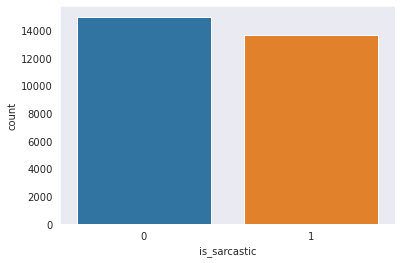

In [6]:
import seaborn as sns

sns. set_style("dark")
sns.countplot(df.is_sarcastic)

## so there are almost same number of sarcastic and non-sarcastic news.



##Lets findsome somewords and clean them because stopwords have no meaning for a sentence. we will use python library to detect them

In [7]:
#first we import all necessary libs
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [8]:
# set and define stop word

stopwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopwd.update(punctuation)

# Now we have to clean unnecessary characters like [],_, htmls etc to clean dataset

In [9]:
#use beautifulsoup library to extract text from html data
def clean_html(text):
    soup=BeautifulSoup(text, "html.parser")
    return soup.get_text()

#remove [], */ etc html tags from text using "re" lib

def remove_betwn_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#remove urls from data

def remove_betwn_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#lets remove stopwords we counted before
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwd:
            final_text.append(i.strip())
    return " ".join(final_text)

#finally we remove all noisy data
def remove_noisy_text(text):
    text = clean_html(text)
    text = remove_betwn_square_brackets(text)
    text = remove_stopwords(text)
    return text




In [10]:
#lets clean the dataset and view

df['headline']=df['headline'].apply(remove_noisy_text)
df['headline']

0        thirtysomething scientists unveil doomsday clo...
1        dem rep. totally nails congress falling short ...
2             eat veggies: 9 deliciously different recipes
3             inclement weather prevents liar getting work
4        mother comes pretty close using word 'streamin...
                               ...                        
28614               jews celebrate rosh hashasha something
28615    internal affairs investigator disappointed con...
28616    beautiful acceptance speech week came queer ko...
28617    mars probe destroyed orbiting spielberg-gates ...
28618                              dad clarifies food stop
Name: headline, Length: 28619, dtype: object

# Lets create a worldcloud from non-sarcastic news which will give us a view of sights which words are used here most

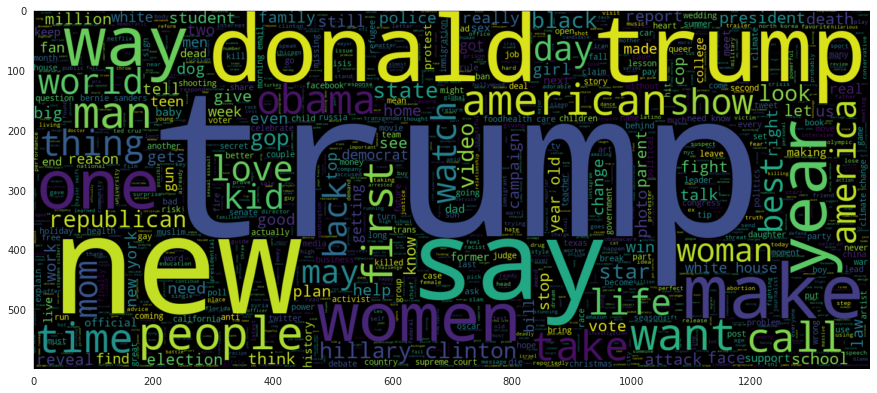

In [11]:
plt.figure(figsize = (15,15)) # non-sarcastic words wordcloud
wordcld = WordCloud(max_words = 3000 , width = 1400 , height = 600).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wordcld , interpolation = 'bilinear')

# Lets create a worldcloud from non-sarcastic news which will give us a view of sights which words are used here most

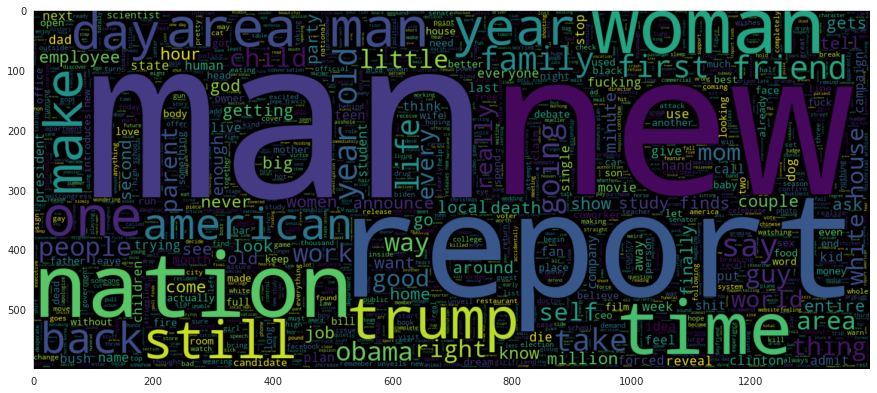

In [12]:
plt.figure(figsize = (15,15)) # non-sarcastic words wordcloud
wordcld = WordCloud(max_words = 3000 , width = 1400 , height = 600).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wordcld , interpolation = 'bilinear')

#  Lets visualize number of words and each word length in dataset

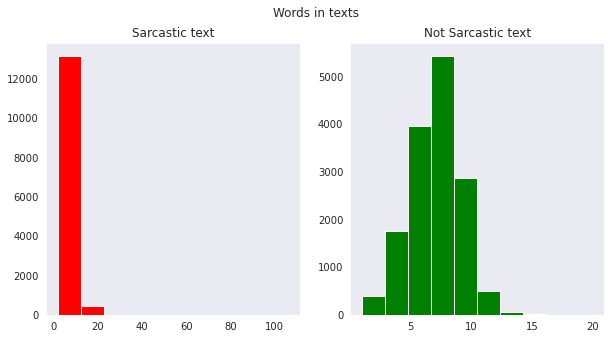

Text(0.5, 0.98, 'Average word length in each text')

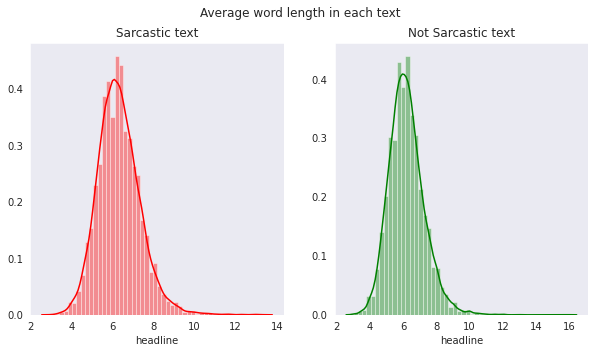

In [13]:
#number of words
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

#average word length
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')


# Now we will use word2vec, tokenization, padding using keras text and word preprocessing libraries. To learn details about wordembedding, visit:(https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

In [14]:
#lets convert our text data into more acceptable format

#split words from a sentence and keep is sentence in the list which will help us for tokenization
words = []
for i in df.headline.values:
    words.append(i.split())
print("splitted words:",words[:5])

# use genism lib for word2vec wordembedding
import gensim
#Dim for max embedding
EMBEDDING_DIM = 200

#lets create word2vec model
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

splitted words: [['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock', 'hair', 'loss'], ['dem', 'rep.', 'totally', 'nails', 'congress', 'falling', 'short', 'gender,', 'racial', 'equality'], ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'], ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'], ['mother', 'comes', 'pretty', 'close', 'using', 'word', "'streaming'", 'correctly']]


## now we will use tokenizer which keep tracks of every word in dataset by assigning an unique token for each word. Also to match length of each sentence, padding can be used

In [15]:
# import keras.preprocessing lib for token
tokenizer = text.Tokenizer(num_words=38071)
tokenizer.fit_on_texts(words)
tokenized_traindata = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_traindata, maxlen = 20)

# lets find vocab length
# after tokenization, new length


In [16]:
print("before tokenization:",len(w2v_model.wv.vocab))
#  vocab size increases by 1
vocab_size = len(tokenizer.word_index) + 1
print("after tokenization, vocab_size:", vocab_size)

before tokenization: 38071
after tokenization, vocab_size: 38072


here we see after tokenization, size increases by 1 because of extra index for unknown words

# Lets create word vectors by creating weight matrix for non-embedding keras layers

In [17]:
#generate weightmatrix using numpy zeros 
weight_matrix=np.zeros((vocab_size, EMBEDDING_DIM))

#lets fill each zeros with value model
for word, k in tokenizer.word_index.items():
        weight_matrix[k] = w2v_model[word]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [18]:
#lets split dataset into train and test

x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0)


# LETS BUILD DEEP LEARNING MODEL AND TRAIN****

In [23]:
#define dnn model
model = Sequential()
#adding embeddidng layers using bidirectional LSTM
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[weight_matrix], input_length=20, trainable=True))

model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.2 , dropout = 0.2,return_sequences = True)))
model.add(Bidirectional(GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.04), loss='binary_crossentropy', metrics=['acc'])

del weight_matrix
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               123648    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,075,073
Trainable params: 8,075,073
Non-trainable params: 0
_________________________________________________________________


## Lets train our model

In [24]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 5)

Epoch 1/5
157/157 [==============================] - 61s 389ms/step - loss: 0.7009 - acc: 0.5795 - val_loss: 0.6040 - val_acc: 0.6813
Epoch 2/5
157/157 [==============================] - 60s 384ms/step - loss: 0.4551 - acc: 0.7876 - val_loss: 0.5084 - val_acc: 0.7598
Epoch 3/5
157/157 [==============================] - 60s 383ms/step - loss: 0.2828 - acc: 0.8839 - val_loss: 0.5981 - val_acc: 0.7671
Epoch 4/5
157/157 [==============================] - 60s 382ms/step - loss: 0.2174 - acc: 0.9150 - val_loss: 0.6269 - val_acc: 0.7604
Epoch 5/5
157/157 [==============================] - 60s 379ms/step - loss: 0.1824 - acc: 0.9290 - val_loss: 0.6462 - val_acc: 0.7696


## Lets analyze training and validation accuracy/loss

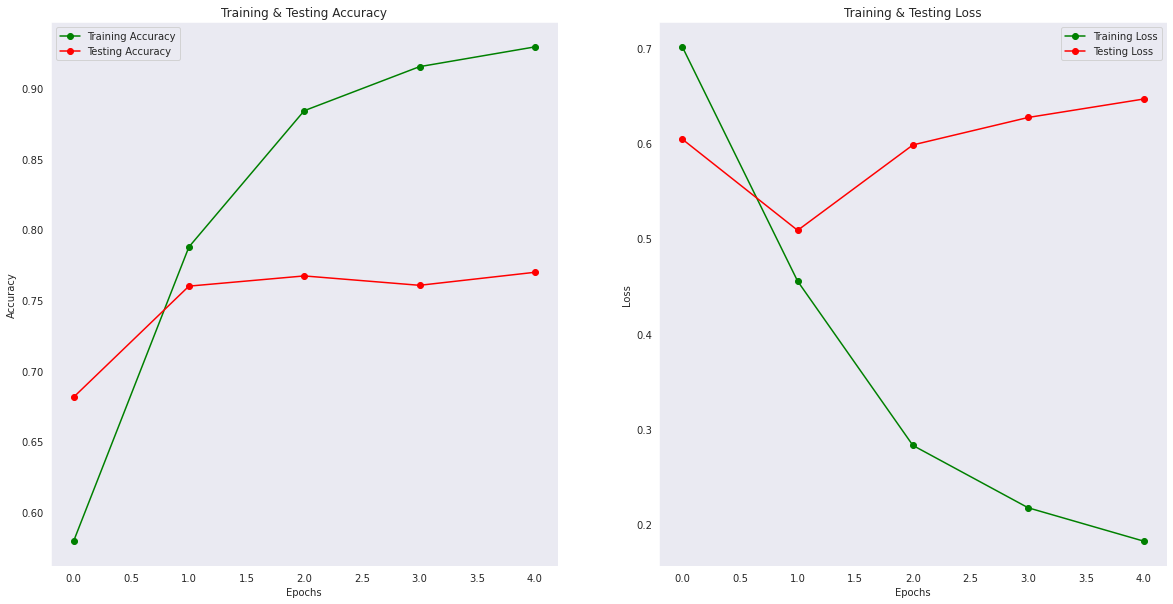

In [25]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# The model needs tuning.. Its overfitting.

# Lets make predictions

In [26]:
predict = model.predict_classes(x_test)
predict[:10]

array([[1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

## Predictions are one hot encoded.. we need to decode it to see in original form. We can decode using decoder.

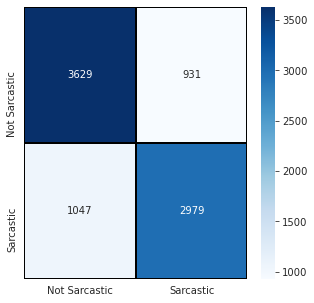

In [29]:
#lets use confusion matrix to check on predictions
conmat=confusion_matrix(y_test,predict)
conmat = pd.DataFrame(conmat , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(conmat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

# lets perform precission, recall, f1 on our model performance

In [31]:
print(classification_report(y_test, predict, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.78      0.80      0.79      4560
    Sarcastic       0.76      0.74      0.75      4026

     accuracy                           0.77      8586
    macro avg       0.77      0.77      0.77      8586
 weighted avg       0.77      0.77      0.77      8586



# Please upvote this notebook if you find this useful**